# NLP Lab Task — Preprocessing to Deployment with Twitter Sentiment Dataset

## Overview

This lab takes students through the **entire NLP pipeline** using a **Twitter Sentiment Analysis dataset** (tweets labeled as positive, negative, or neutral). Students will preprocess the data, represent it using multiple methods, train classical machine learning models, evaluate their results, and finally build a small API for deployment.

---

## Learning Objectives

* Apply text preprocessing (regex, case folding, tokenization, stopword removal, punctuation handling).
* Compare stemming and lemmatization, and use POS tagging to analyze counts of nouns, verbs, and adjectives.
* Build text representations using **Bag-of-Words**, **TF–IDF**, and **Word2Vec**.
* Train classical ML models inside an sklearn **Pipeline**.
* Evaluate models with standard metrics and perform basic error analysis.
* Save a trained pipeline and build a simple API to serve predictions.

---

## Dataset

We will use the **Sentiment140 Twitter dataset** (1.6M tweets, labeled positive/negative). For simplicity, you can work with a smaller balanced subset (e.g., 10k–20k tweets). This dataset is widely used for sentiment analysis and contains real, noisy text with mentions, hashtags, and emoticons.

Dataset link: [Sentiment140](http://help.sentiment140.com/for-students/)

---

## Step-by-Step Tasks

### 1) Exploratory Data Analysis (EDA)

* Load dataset, show class distribution, tweet length histogram, and a few sample tweets.
* Deliverable: 3 plots (class balance, length histogram, top frequent tokens) + 5 example tweets.

### 2) Regex Cleaning

* Remove URLs, mentions (@user), hashtags, emojis (or replace with tokens), and extra whitespace.
* Show a before-and-after example for at least 3 tweets.

### 3) Case Folding & Tokenization

* Convert all text to lowercase.
* Tokenize tweets using NLTK or spaCy.
* Compare vocabulary size before and after cleaning.

### 4) Stopwords, Punctuation, and Numbers

* Remove stopwords (with NLTK list, customizable).
* Decide how to handle punctuation and numbers (remove or replace with `<NUM>`).
* Deliverable: short explanation of your choice.

### 5) Stemming vs Lemmatization

* Use PorterStemmer (stemming) and spaCy lemmatizer.
* Show 20 sample words with their stem vs lemma.
* Train quick models with both and compare results.

### 6) POS Tagging (extra features)

* Use spaCy to count nouns, verbs, and adjectives per tweet.
* Add these counts as additional numeric features.
* Compare model with vs without POS features.

### 7) Text Representation

* Implement three representations:
  1. **Bag-of-Words** (CountVectorizer)
  2. **TF–IDF** (TfidfVectorizer)
  3. **Word2Vec** (pretrained embeddings, averaged per tweet)
* Compare vocabulary sizes and representation dimensions.

### 8) Modeling with Pipelines

* Use sklearn Pipelines to connect preprocessing + vectorizer + classifier.
* Models to try:
  * Multinomial Naive Bayes (for BoW/TF–IDF)
  * Logistic Regression
  * Linear SVM
* Deliverable: comparison table (accuracy, F1-score).

### 9) Evaluation & Error Analysis

* Use held-out test set.
* Metrics: accuracy, precision, recall, F1, confusion matrix.
* Show 10 misclassified tweets and discuss why they may be difficult.

### 10) Save Model Pipeline

* Save the best pipeline using `joblib` or `pickle`.
* Deliverable: `sentiment_model.pkl` file.

### 11) Build a Simple API (Deployment Step)

* Create a small Flask API with one endpoint `/predict` that accepts a tweet as input and returns sentiment prediction.
* The API should load the saved pipeline and make predictions.
* Deliverable: `app.py` with Flask code + test with a sample curl or Postman request.

---

## Deliverables

1. Jupyter Notebook with step-by-step tasks, results, and code.
2. Comparison tables for preprocessing choices and representations.
3. Saved pipeline file (`.pkl`).
4. Flask API script (`app.py`).
5. Short report in markdown cell summarizing preprocessing, modeling choices, and results.

---

This streamlined lab ensures students get hands-on experience with **real-world text preprocessing, classical modeling, and deployment of NLP systems**.


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Load the Dataset

We will use the **Sentiment140 Twitter Sentiment dataset**.  
It contains 1.6 million tweets labeled as positive (4) or negative (0).  
For this lab, we will load a smaller subset (e.g., 20,000 rows) for faster experimentation.

```python
import pandas as pd

# Column order for Sentiment140 dataset:
# 0 - target (0 = negative, 4 = positive)
# 1 - ids
# 2 - date
# 3 - flag
# 4 - user
# 5 - text (tweet)

# Update the file path if needed
file_path = "sentiment140.csv"

# Load with proper encoding
df = pd.read_csv(file_path, encoding='latin-1', header=None)

# Assign column names
df.columns = ["target", "id", "date", "flag", "user", "text"]

# Map target labels: 0 → negative, 4 → positive
df["target"] = df["target"].map({0: "negative", 4: "positive"})

# Take a smaller sample for experiments (optional)
df = df.sample(20000, random_state=42).reset_index(drop=True)

# Quick check
print(df.shape)
df.head()


In [2]:
import pandas as pd

import pandas as pd
import zipfile
import os
import requests

# Step 1: Download the dataset (if not already downloaded)
url = "https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
zip_path = "trainingandtestdata.zip"

if not os.path.exists(zip_path):
    print("Downloading dataset...")
    r = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(r.content)

# Step 2: Unzip the file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")

# Step 3: Load training data
file_path = "training.1600000.processed.noemoticon.csv"

df = pd.read_csv(file_path, encoding="latin-1", header=None)
df.columns = ["target", "id", "date", "flag", "user", "text"]

# Map sentiment labels: 0 = negative, 4 = positive
df["target"] = df["target"].map({0: "negative", 4: "positive"})

# Optional: sample a smaller dataset for quicker experiments
df = df.sample(30000, random_state=42).reset_index(drop=True)

# Preview the data
print(df.shape)
df.head()


# Load training set
train_path = "training.1600000.processed.noemoticon.csv"
train_df = pd.read_csv(train_path, encoding="latin-1", header=None)
train_df.columns = ["target", "id", "date", "flag", "user", "text"]
train_df["target"] = train_df["target"].map({0: "negative", 4: "positive"})

print("Training set:", train_df.shape)
print(train_df.head())

# Load manual test set
test_path = "testdata.manual.2009.06.14.csv"
test_df = pd.read_csv(test_path, encoding="latin-1", header=None)
test_df.columns = ["target", "id", "date", "flag", "user", "text"]

# This test set has labels 0 (negative), 2 (neutral), 4 (positive)
test_df["target"] = test_df["target"].map({0: "negative", 2: "neutral", 4: "positive"})

print("Test set:", test_df.shape)
print(test_df.head())


(30000, 6)
Training set: (1600000, 6)
     target          id                          date      flag  \
0  negative  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1  negative  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2  negative  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3  negative  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4  negative  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
Test set: (498, 6)
     target  id                          date     flag      user  \
0  positive   3  Mon May 11 03:17:40 UTC

## EDA

In [3]:
train_df["target"].value_counts()

,count
target,
negative,800000
positive,800000


In [4]:
test_df["target"].value_counts()

,count
target,
positive,182
negative,177
neutral,139


In [5]:
df_with_lengths = df[["text","target"]].copy()




print(df_with_lengths['target'].value_counts())
print(df_with_lengths.shape)

df_with_lengths["length"] = df["text"].str.len()

print(df_with_lengths.head())

target
positive    15001
negative    14999
Name: count, dtype: int64
(30000, 2)
                                                text    target  length
0             @chrishasboobs AHHH I HOPE YOUR OK!!!   negative      38
1  @misstoriblack cool , i have no tweet apps  fo...  negative      57
2  @TiannaChaos i know  just family drama. its la...  negative     137
3  School email won't open  and I have geography ...  negative      91
4                             upper airways problem   negative      22


Text(0.5, 1.0, 'Distribution of Tweet Lengths by Sentiment')

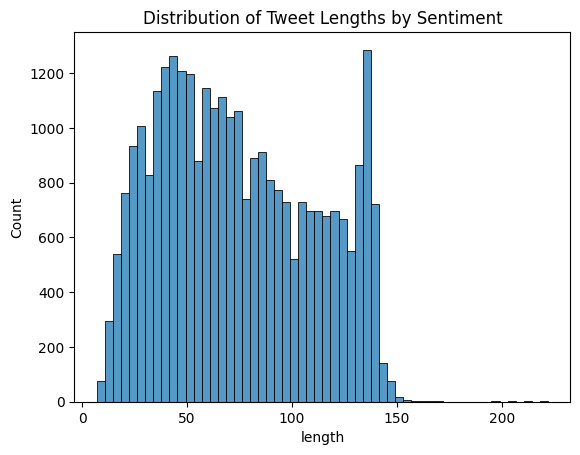

In [6]:
sns.histplot(data=df_with_lengths, x="length")
plt.title("Distribution of Tweet Lengths by Sentiment")

In [7]:
df_with_lengths["length"].describe()

,length
count,30000.00000
mean,74.25390
std,36.49954
min,7.00000
25%,44.00000
50%,70.00000
75%,104.00000
max,222.00000


In [8]:
df_with_lengths.groupby("target")["length"].mean()

,length
target,
negative,74.085806
positive,74.421972


In [9]:
df_with_lengths[df_with_lengths["length"] >150]["text"].head(10)

,text
60,@bing siteowner custom search box fail... &quo...
1254,When someone says &quot;I had a nightmare abou...
2373,&quot;The Skynet has you...&quot; (Ñ?ÑÐ¾ ÑÐ»...
2767,@tobinharris Does yUML support Interface + Cla...
4995,on my way to freedom - feels like i've been tr...
5556,"èªª åé«éå¾ç¬¬ä¸å (LOL),æ²æ³å°è?¸å®..."
5923,@tommcfly haave you ever thought about coming ...
9297,&quot;Only those who have learned the power of...
9712,YOoooooooOOOO GET @ MEH&lt;&lt;&lt;&lt;&lt;&lt...
11046,In love with Sunrise's song 6-0 It's so gay a...


In [ ]:

# for i in range(30):
#     long_tweet = df_with_lengths[df_with_lengths["length"] > 150]["text"].iloc[i]
#     print(long_tweet)


From my analysis so far, I can conclude that the main text patterns to handle during preprocessing are:

- Links/URLs

- Dates

- Numbers/digits

- Mentions and usernames => @ -----

- HTML entities => Transform them back to their real characters  (&gt)  then remove
   -  => html.unescape(text)

#### top frequent tokens before preprocessing

In [10]:
from collections import Counter
import re


all_words = " ".join(df["text"]).lower()


tokens = re.findall(r'\b\w+\b', all_words)


top_tokens = Counter(tokens).most_common(20)
print(top_tokens)


[('i', 17947), ('to', 10567), ('the', 9794), ('a', 7289), ('my', 5854), ('you', 5763), ('it', 5726), ('and', 5623), ('is', 4411), ('in', 4057), ('for', 4045), ('t', 3465), ('s', 3465), ('of', 3285), ('that', 3112), ('on', 3094), ('me', 3038), ('so', 2851), ('have', 2749), ('m', 2606)]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'i'),
  Text(1, 0, 'to'),
  Text(2, 0, 'the'),
  Text(3, 0, 'a'),
  Text(4, 0, 'my'),
  Text(5, 0, 'you'),
  Text(6, 0, 'it'),
  Text(7, 0, 'and'),
  Text(8, 0, 'is'),
  Text(9, 0, 'in'),
  Text(10, 0, 'for'),
  Text(11, 0, 't'),
  Text(12, 0, 's'),
  Text(13, 0, 'of'),
  Text(14, 0, 'that'),
  Text(15, 0, 'on'),
  Text(16, 0, 'me'),
  Text(17, 0, 'so'),
  Text(18, 0, 'have'),
  Text(19, 0, 'm')])

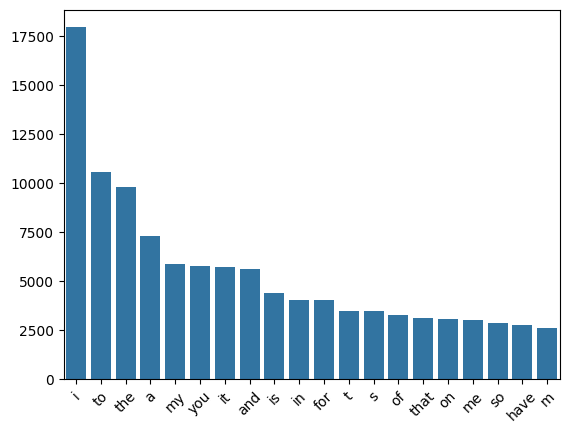

In [11]:
sns.barplot(x=[token[0] for token in top_tokens], y=[token[1] for token in top_tokens])
plt.xticks(rotation=45)

I used only df, a sample of the dataset (due to memory limitations). Almost all of the top 20 most frequent tokens turned out to be stopwords. Therefore, we should remove stopwords during preprocessing.

----

## Regex Cleaning

In [12]:
import html
def Regex_cleaning(text) :
    text = html.unescape(str(text))
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # remove URLs
    text = re.sub(r'\@\w+|\#','', text) # remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text) # remove special characters and punctuation
    text = re.sub(r'\s+', ' ', text).strip() # remove extra whitespace
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+', '', text) # remove emojis
    text = re.sub(r'\d+', '', text) # remove numbers
    return text

In [13]:
df_with_lengths["cleaned_text"] = df_with_lengths["text"].apply(Regex_cleaning)
df["cleaned_text"] = df["text"].apply(Regex_cleaning)


In [14]:
df_with_lengths[["text","cleaned_text"]]

,text,cleaned_text
0,@chrishasboobs AHHH I HOPE YOUR OK!!!,AHHH I HOPE YOUR OK
1,"@misstoriblack cool , i have no tweet apps fo...",cool i have no tweet apps for my razr
2,@TiannaChaos i know just family drama. its la...,i know just family drama its lamehey next time...
3,School email won't open and I have geography ...,School email wont open and I have geography st...
4,upper airways problem,upper airways problem
...,...,...
29995,Bout to go eat all you can eat sushi by @Phobo...,Bout to go eat all you can eat sushi by s hous...
29996,guess the only bus you ride now is your own to...,guess the only bus you ride now is your own to...
29997,"Hmmm, might go to bed",Hmmm might go to bed
29998,This sounds suspiciously like Year of a Millio...,This sounds suspiciously like Year of a Millio...


In [15]:
y=df_with_lengths[["text","cleaned_text"]].iloc[29995]
print("original text:", y['text'])
print("cleaned text :",y['cleaned_text'])

original text: Bout to go eat all you can eat sushi by @Phoboy86's house. Hopefully I eat enough to make me really sleepy cuz I have to wake up at 3:30 
cleaned text : Bout to go eat all you can eat sushi by s house Hopefully I eat enough to make me really sleepy cuz I have to wake up at 


----

#### Case Folding & Tokenization

In [17]:
from nltk.tokenize import word_tokenize


In [18]:
import nltk
nltk.data.path.append(r"C:\Users\Abdallah\AppData\Roaming\nltk_data")


In [19]:
from nltk.tokenize import word_tokenize

In [20]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()
df_with_lengths["Tokenized_Text"] = df_with_lengths.apply(
    lambda row: tokenizer.tokenize(row["cleaned_text"].lower()), axis=1
)
display(df_with_lengths[["cleaned_text", "Tokenized_Text"]].head())

,cleaned_text,Tokenized_Text
0,AHHH I HOPE YOUR OK,"[ahhh, i, hope, your, ok]"
1,cool i have no tweet apps for my razr,"[cool, i, have, no, tweet, apps, for, my, razr]"
2,i know just family drama its lamehey next time...,"[i, know, just, family, drama, its, lamehey, n..."
3,School email wont open and I have geography st...,"[school, email, wont, open, and, i, have, geog..."
4,upper airways problem,"[upper, airways, problem]"


----

## Stemming and Lemmatization

### PorterStemmer

In [23]:
import nltk
from nltk.stem import PorterStemmer


# Download resources for NLTK
nltk.download("wordnet")
nltk.download("omw-1.4")

# Initialize tools
stemmer = PorterStemmer()
def stemming (tokens) :
  stems = [stemmer.stem(w) for w in tokens]
  return stems




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [24]:
df_with_lengths["porter_stemmer"] = df_with_lengths["Tokenized_Text"].apply(stemming)

df_with_lengths[["porter_stemmer", "Tokenized_Text"]].head()

,porter_stemmer,Tokenized_Text
0,"[ahhh, i, hope, your, ok]","[ahhh, i, hope, your, ok]"
1,"[cool, i, have, no, tweet, app, for, my, razr]","[cool, i, have, no, tweet, apps, for, my, razr]"
2,"[i, know, just, famili, drama, it, lamehey, ne...","[i, know, just, family, drama, its, lamehey, n..."
3,"[school, email, wont, open, and, i, have, geog...","[school, email, wont, open, and, i, have, geog..."
4,"[upper, airway, problem]","[upper, airways, problem]"


### spaCy lemmatizer + Stop word removal


In [ ]:
# import spacy
# nlp = spacy.load("en_core_web_sm")


# def lemmatize_text(text):

#     doc = nlp(text)
#     lemmas = " ".join([token.lemma_ for token in doc])
#     return lemmas

# df_with_lengths["lemmatized_text"] = df_with_lengths["cleaned_text"].apply(lemmatize_text)


# df_with_lengths[["lemmatized_text", "Tokenized_Text","cleaned_text"]].head()


In [22]:
import spacy
from tqdm import tqdm

# Load spaCy with only components you need (disable parser, ner, textcat for speed)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

texts = df_with_lengths["cleaned_text"].tolist()

lemmatized = []

# tqdm shows a progress bar
for doc in tqdm(nlp.pipe(texts, batch_size=500, n_process=-1), total=len(texts)):
    lemmas = " ".join([token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop])
    lemmatized.append(lemmas)

df_with_lengths["lemmatized_text"] = lemmatized

df_with_lengths[["lemmatized_text", "Tokenized_Text","porter_stemmer",  "cleaned_text"]].head()


100%|██████████| 30000/30000 [02:03<00:00, 242.28it/s]


KeyError: "['porter_stemmer'] not in index"

In [25]:
df_with_lengths[["lemmatized_text", "Tokenized_Text","porter_stemmer",  "cleaned_text"]].head()


,lemmatized_text,Tokenized_Text,porter_stemmer,cleaned_text
0,ahhh hope ok,"[ahhh, i, hope, your, ok]","[ahhh, i, hope, your, ok]",AHHH I HOPE YOUR OK
1,cool tweet app razr,"[cool, i, have, no, tweet, apps, for, my, razr]","[cool, i, have, no, tweet, app, for, my, razr]",cool i have no tweet apps for my razr
2,know family drama lamehey time u hang kim n u ...,"[i, know, just, family, drama, its, lamehey, n...","[i, know, just, famili, drama, it, lamehey, ne...",i know just family drama its lamehey next time...
3,school email will not open geography stuff rev...,"[school, email, wont, open, and, i, have, geog...","[school, email, wont, open, and, i, have, geog...",School email wont open and I have geography st...
4,upper airway problem,"[upper, airways, problem]","[upper, airway, problem]",upper airways problem


------

### Pos Tagging as additional numeric features.


In [ ]:


# nlp = spacy.load("en_core_web_sm")


# def count_pos(text):

#     doc = nlp(text)
#     num_verbs = sum(1 for token in doc if token.pos_ == "VERB")
#     num_nouns = sum(1 for token in doc if token.pos_ == "NOUN")
#     num_adjectives = sum(1 for token in doc if token.pos_ == "ADJ")
#     return pd.Series({'num_verbs': num_verbs, 'num_nouns': num_nouns , 'num_adjectives':num_adjectives})

# df_with_lengths[['num_verbs', 'num_nouns','num_adjectives']] = df_with_lengths['cleaned_text'].apply(count_pos)

# print(df_with_lengths)

In [28]:
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
# disable unneeded components for speed

def count_pos_pipe(texts):
    num_verbs, num_nouns, num_adjectives = [], [], []

    # Use pipe for batch processing (much faster!)
    for doc in nlp.pipe(texts, batch_size=1000, n_process=-1):
        v = sum(1 for token in doc if token.pos_ == "VERB")
        n = sum(1 for token in doc if token.pos_ == "NOUN")
        a = sum(1 for token in doc if token.pos_ == "ADJ")
        num_verbs.append(v)
        num_nouns.append(n)
        num_adjectives.append(a)

    return pd.DataFrame({
        "num_verbs": num_verbs,
        "num_nouns": num_nouns,
        "num_adjectives": num_adjectives
    })

# Apply to your dataset
df_with_lengths[["num_verbs", "num_nouns", "num_adjectives"]] = count_pos_pipe(df_with_lengths["cleaned_text"])


In [29]:
df_with_lengths[['num_verbs', 'num_nouns','num_adjectives','cleaned_text']]

,num_verbs,num_nouns,num_adjectives,cleaned_text
0,1,1,0,AHHH I HOPE YOUR OK
1,0,3,0,cool i have no tweet apps for my razr
2,2,7,2,i know just family drama its lamehey next time...
3,2,4,0,School email wont open and I have geography st...
4,0,2,1,upper airways problem
...,...,...,...,...
29995,6,3,1,Bout to go eat all you can eat sushi by s hous...
29996,2,4,3,guess the only bus you ride now is your own to...
29997,1,1,0,Hmmm might go to bed
29998,1,2,0,This sounds suspiciously like Year of a Millio...


In [30]:
df_with_lengths.head()


,text,target,length,cleaned_text,Tokenized_Text,lemmatized_text,porter_stemmer,num_verbs,num_nouns,num_adjectives
0,@chrishasboobs AHHH I HOPE YOUR OK!!!,negative,38,AHHH I HOPE YOUR OK,"[ahhh, i, hope, your, ok]",ahhh hope ok,"[ahhh, i, hope, your, ok]",1,1,0
1,"@misstoriblack cool , i have no tweet apps fo...",negative,57,cool i have no tweet apps for my razr,"[cool, i, have, no, tweet, apps, for, my, razr]",cool tweet app razr,"[cool, i, have, no, tweet, app, for, my, razr]",0,3,0
2,@TiannaChaos i know just family drama. its la...,negative,137,i know just family drama its lamehey next time...,"[i, know, just, family, drama, its, lamehey, n...",know family drama lamehey time u hang kim n u ...,"[i, know, just, famili, drama, it, lamehey, ne...",2,7,2
3,School email won't open and I have geography ...,negative,91,School email wont open and I have geography st...,"[school, email, wont, open, and, i, have, geog...",school email will not open geography stuff rev...,"[school, email, wont, open, and, i, have, geog...",2,4,0
4,upper airways problem,negative,22,upper airways problem,"[upper, airways, problem]",upper airway problem,"[upper, airway, problem]",0,2,1


------

In [31]:
df_with_lengths["target"] = df_with_lengths.apply(
    lambda row: 0 if row["target"] == "negative" else 1,
    axis=1
)

In [32]:
df_with_lengths["target"].value_counts()

,count
target,
1,15001
0,14999


### Text Representation




#### **Bag-of-Words**

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
from scipy.sparse import hstack

X_train_BOW, X_test_BOW, y_train_BOW, y_test_BOW = train_test_split(df_with_lengths[["length","lemmatized_text",	"num_verbs",	"num_nouns",	"num_adjectives"]], df_with_lengths['target'], test_size=0.2, random_state=42)

vectorizer = CountVectorizer(min_df=5,max_df=0.9)
##########################################
X_train_bow = vectorizer.fit_transform(X_train_BOW["lemmatized_text"])
X_test_bow = vectorizer.transform(X_test_BOW["lemmatized_text"])
X_train_bow_dense = X_train_bow.toarray()
feature_names = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(X_train_bow_dense, columns=feature_names)

##############################################
X_train_num_bow = X_train_BOW[["length", "num_verbs", "num_nouns", "num_adjectives"]].values
X_test_num_bow = X_test_BOW[["length", "num_verbs", "num_nouns", "num_adjectives"]].values

X_train_final_bow = hstack([X_train_bow, X_train_num_bow])
X_test_final_bow = hstack([X_test_bow, X_test_num_bow])

In [41]:
print(bow_df.head())

   aaah  aaron  abandon  ability  able  absolutely  abt  ac  accent  accept  \
0     0      0        0        0     0           0    0   0       0       0   
1     0      0        0        0     0           0    0   0       0       0   
2     0      0        0        0     0           0    0   0       0       0   
3     0      0        0        0     0           0    0   0       0       0   
4     0      0        0        0     0           0    0   0       0       0   

   ...  yrs  yu  yuck  yucky  yum  yummy  yup  zealand  zone  zoo  
0  ...    0   0     0      0    0      0    0        0     0    0  
1  ...    0   0     0      0    0      0    0        0     0    0  
2  ...    0   0     0      0    0      0    0        0     0    0  
3  ...    0   0     0      0    0      0    0        0     0    0  
4  ...    0   0     0      0    0      0    0        0     0    0  

[5 rows x 3208 columns]


In [42]:
feature_names

array(['aaah', 'aaron', 'abandon', ..., 'zealand', 'zone', 'zoo'],
      dtype=object)

In [43]:
import pandas as pd

print(pd.DataFrame(feature_names, columns=["feature_name"]))


     feature_name
0            aaah
1           aaron
2         abandon
3         ability
4            able
...           ...
3203        yummy
3204          yup
3205      zealand
3206         zone
3207          zoo

[3208 rows x 1 columns]


------

#### **TF–IDF**

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Train-test split
X_train_TFIDF, X_test_TFIDF, y_train_TFIDF, y_test_TFIDF = train_test_split(df_with_lengths[["length", "lemmatized_text", "num_verbs", "num_nouns", "num_adjectives"]],df_with_lengths['target'],test_size=0.2,random_state=42)

# Vectorizer (TF–IDF instead of BoW)
tfidf_vectorizer = TfidfVectorizer(min_df=5,max_df=0.9)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_TFIDF["lemmatized_text"])
X_test_tfidf = tfidf_vectorizer.transform(X_test_TFIDF["lemmatized_text"])
X_train_tfidf_dense=X_train_tfidf.toarray()
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X_train_tfidf_dense, columns=feature_names)

# Numeric features
X_train_num_tfidf = X_train_TFIDF[["length", "num_verbs", "num_nouns", "num_adjectives"]].values
X_test_num_tfidf = X_test_TFIDF[["length", "num_verbs", "num_nouns", "num_adjectives"]].values

# Combine text + numeric features
X_train_final_tfidf = hstack([X_train_tfidf, X_train_num_tfidf])
X_test_final_tfidf = hstack([X_test_tfidf, X_test_num_tfidf])

print("Final TFIDF train shape:", X_train_final_tfidf.shape)
print("Final TFIDF test shape:", X_test_final_tfidf.shape)


Final TFIDF train shape: (24000, 3212)
Final TFIDF test shape: (6000, 3212)


In [48]:
tfidf_df

,aaah,aaron,abandon,ability,able,absolutely,abt,ac,accent,accept,...,yrs,yu,yuck,yucky,yum,yummy,yup,zealand,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-----

#### **Word2Vec**

In [ ]:
!pip install gensim


In [49]:
from gensim.models import Word2Vec
import numpy as np

sentences = [text.split() for text in df_with_lengths["lemmatized_text"]]
w2v_model = Word2Vec(sentences, vector_size=200, window=5, min_count=5, sg=0, workers=4)






In [51]:
# List of all words in the trained model
unique_words = list(w2v_model.wv.key_to_index.keys())
print(unique_words)  # show first 20 words
print(len(unique_words))  # total number of unique words


['not', 'm', 'go', 'day', 'good', 'get', 'work', 'like', 's', 'love', 'today', 'time', 'think', 'want', 'know', 'thank', 'lol', 'miss', 'feel', 'u', 'come', 'watch', 'night', 'need', 'new', 'home', 'look', 'oh', 'hope', 'sleep', 'bad', 'wish', 'great', 'morning', 'twitter', 'wait', 'tomorrow', 'ill', 'to', 've', 'sad', 'try', 'haha', 'sorry', 'week', 'right', 'fun', 'happy', 'nice', 'thing', 'tonight', 'find', 'well', 'friend', 'hate', 'way', 'leave', 'bed', 'start', 'd', 'say', 'tweet', 'follow', 'yeah', 'people', 'school', 'long', 'hour', 'play', 'see', 'awesome', 'eat', 'weekend', 'guy', 'soon', 'little', 'hey', 'yes', 'make', 'have', 'let', 'hear', 'sick', 'wanna', 'tell', 'movie', 'cool', 'year', 'early', 'will', 'life', 'x', 'help', 'girl', 'take', 'ok', 'man', 'head', 'phone', 'talk', 'sure', 'lose', 'tired', 'wake', 'enjoy', 'big', 'song', 'old', 'lot', 'hurt', 'yay', 'suck', 'rain', 'game', 'mean', 'maybe', 'pretty', 'live', 'buy', 'read', 'away', 'ready', 'listen', 'amazing',

In [52]:
# Function to average embeddings for each text
def get_avg_embedding(tokens, model):
    vectors = []
    for token in tokens:
        if token in model.wv:   # check if word is in vocab
            vectors.append(model.wv[token])
    if vectors:  # average only if there are vectors
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # empty doc -> zero vector

In [53]:

df_with_lengths["w2v_embedding"] = sentences
df_with_lengths["w2v_embedding"] = df_with_lengths["w2v_embedding"].apply(
    lambda tokens: get_avg_embedding(tokens, w2v_model)
)


print(df_with_lengths[["lemmatized_text", "w2v_embedding"]].head())


                                     lemmatized_text  \
0                                       ahhh hope ok   
1                                cool tweet app razr   
2  know family drama lamehey time u hang kim n u ...   
3  school email will not open geography stuff rev...   
4                               upper airway problem   

                                       w2v_embedding  
0  [0.025168657, -0.15183085, 0.05627547, 0.16273...  
1  [0.027647287, -0.20099868, 0.12060496, 0.15485...  
2  [0.030279983, -0.19882627, 0.11319213, 0.15298...  
3  [0.02868397, -0.16980436, 0.07918595, 0.152402...  
4  [0.012076834, -0.10418283, 0.053680986, 0.0856...  


______

### ***Modeling***
### **Baseline models without hyperparameters tuning**

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracies = []
precisions = []
recalls = []
f1s = []

#### **Bag-of-Words**

##### **Logistic Regression text only**

In [55]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_bow, y_train_BOW)

LogisticRegression(max_iter=2000)

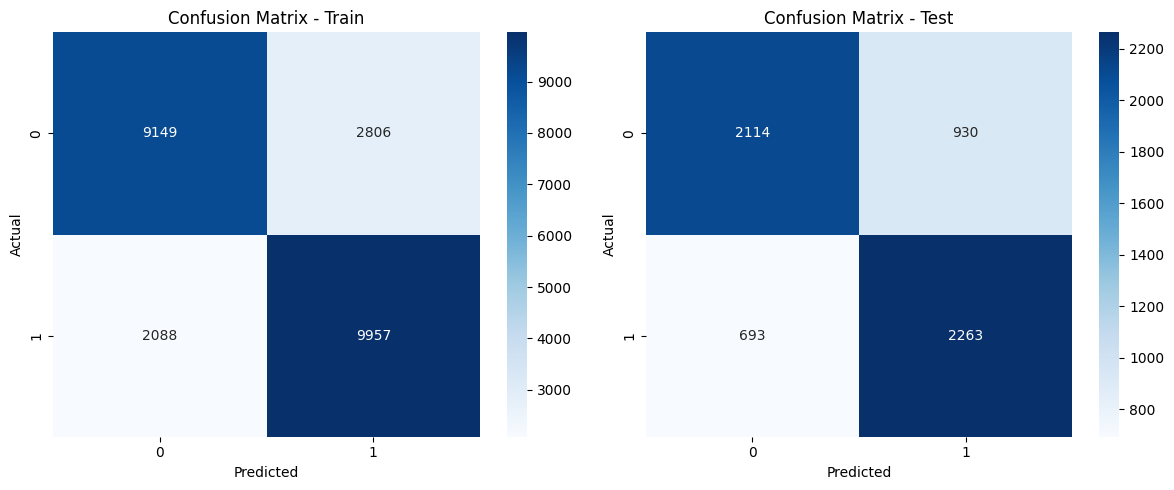

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_pred_bow_test = logreg.predict(X_test_bow)
y_pred_bow_train = logreg.predict(X_train_bow)
cm_test = confusion_matrix(y_test_BOW, y_pred_bow_test)
cm_train = confusion_matrix(y_train_BOW, y_pred_bow_train)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()


In [57]:
from sklearn.metrics import classification_report

print(classification_report(y_test_BOW, y_pred_bow_test))
print(classification_report(y_train_BOW, y_pred_bow_train))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72      3044
           1       0.71      0.77      0.74      2956

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000

              precision    recall  f1-score   support

           0       0.81      0.77      0.79     11955
           1       0.78      0.83      0.80     12045

    accuracy                           0.80     24000
   macro avg       0.80      0.80      0.80     24000
weighted avg       0.80      0.80      0.80     24000



In [58]:
accuracies.append(accuracy_score(y_test_BOW, y_pred_bow_test))
precisions.append(precision_score(y_test_BOW, y_pred_bow_test))
recalls.append(recall_score(y_test_BOW, y_pred_bow_test))
f1s.append(f1_score(y_test_BOW, y_pred_bow_test))

______

##### **Logistic Regression text + extra numerical features**






In [59]:
logreg_2 = LogisticRegression(max_iter=2000)
logreg_2.fit(X_train_final_bow, y_train_BOW)

LogisticRegression(max_iter=2000)

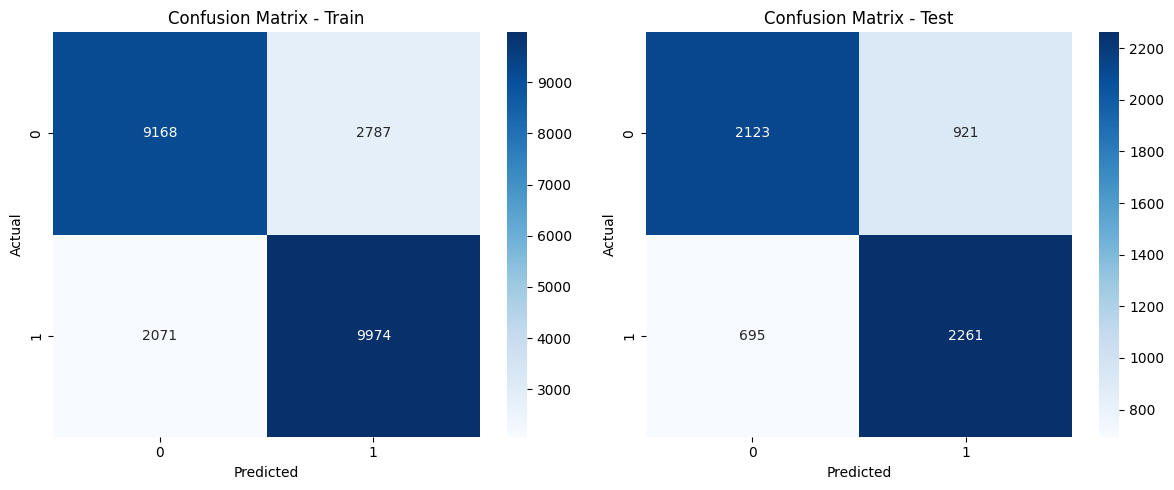

In [60]:
y_pred_bow_final=logreg_2.predict(X_test_final_bow)
y_pred_bow_train=logreg_2.predict(X_train_final_bow)
cm_test = confusion_matrix(y_test_BOW, y_pred_bow_final)
cm_train = confusion_matrix(y_train_BOW, y_pred_bow_train)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [61]:
from sklearn.metrics import classification_report
print("========================= test =================")
print(classification_report(y_test_BOW, y_pred_bow_final))
print("====================================================")
print("========================= train =================")
print(classification_report(y_train_BOW, y_pred_bow_train))

========================= test =================
              precision    recall  f1-score   support

           0       0.75      0.70      0.72      3044
           1       0.71      0.76      0.74      2956

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000

========================= train =================
              precision    recall  f1-score   support

           0       0.82      0.77      0.79     11955
           1       0.78      0.83      0.80     12045

    accuracy                           0.80     24000
   macro avg       0.80      0.80      0.80     24000
weighted avg       0.80      0.80      0.80     24000



In [62]:
accuracies.append(accuracy_score(y_test_BOW, y_pred_bow_final))
precisions.append(precision_score(y_test_BOW, y_pred_bow_final))
recalls.append(recall_score(y_test_BOW, y_pred_bow_final))
f1s.append(f1_score(y_test_BOW, y_pred_bow_final))

------

##### **Linear SVM text only**

In [63]:
from sklearn.svm import SVC

svm_1=SVC(kernel='linear',C=1.0,random_state=42)
svm_1.fit(X_train_bow, y_train_BOW)

SVC(kernel='linear', random_state=42)

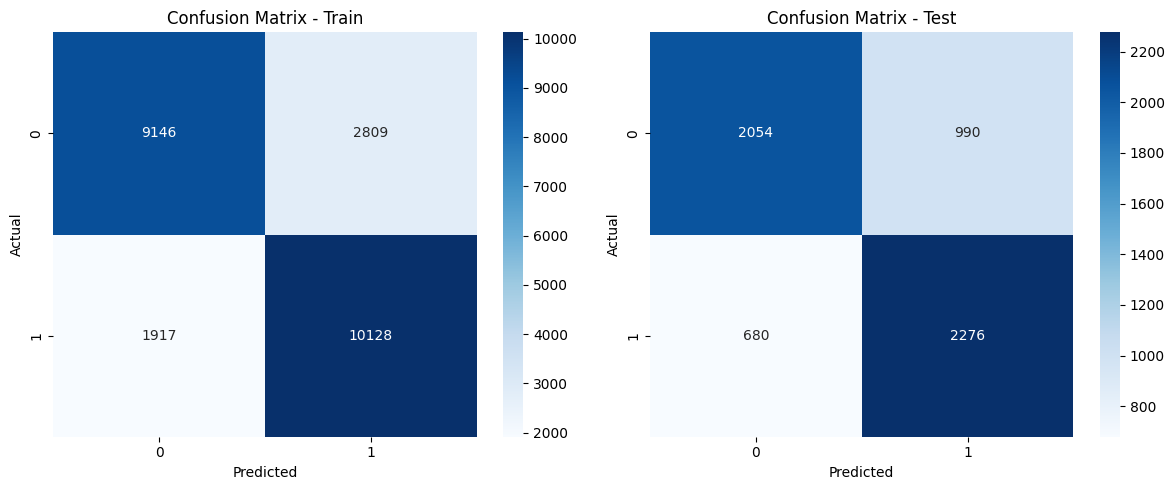

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_bow_text=svm_1.predict(X_test_bow)
y_pred_bow_text_train=svm_1.predict(X_train_bow)
cm_test = confusion_matrix(y_test_BOW, y_pred_bow_text)
cm_train = confusion_matrix(y_train_BOW, y_pred_bow_text_train)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



In [65]:
from sklearn.metrics import classification_report
print("========================= test =================")
print(classification_report(y_test_BOW, y_pred_bow_text))
print("====================================================")
print("========================= train =================")
print(classification_report(y_train_BOW, y_pred_bow_text_train))


========================= test =================
              precision    recall  f1-score   support

           0       0.75      0.67      0.71      3044
           1       0.70      0.77      0.73      2956

    accuracy                           0.72      6000
   macro avg       0.72      0.72      0.72      6000
weighted avg       0.72      0.72      0.72      6000

========================= train =================
              precision    recall  f1-score   support

           0       0.83      0.77      0.79     11955
           1       0.78      0.84      0.81     12045

    accuracy                           0.80     24000
   macro avg       0.80      0.80      0.80     24000
weighted avg       0.80      0.80      0.80     24000



In [66]:
accuracies.append(accuracy_score(y_test_BOW, y_pred_bow_text))
precisions.append(precision_score(y_test_BOW, y_pred_bow_text))
recalls.append(recall_score(y_test_BOW, y_pred_bow_text))
f1s.append(f1_score(y_test_BOW, y_pred_bow_text))

____

##### **Linear SVM text +extra numerical features**

In [67]:
svm_2 = SVC(kernel='linear',C=1.0,random_state=42,)
svm_2.fit(X_train_final_bow, y_train_BOW)

SVC(kernel='linear', random_state=42)

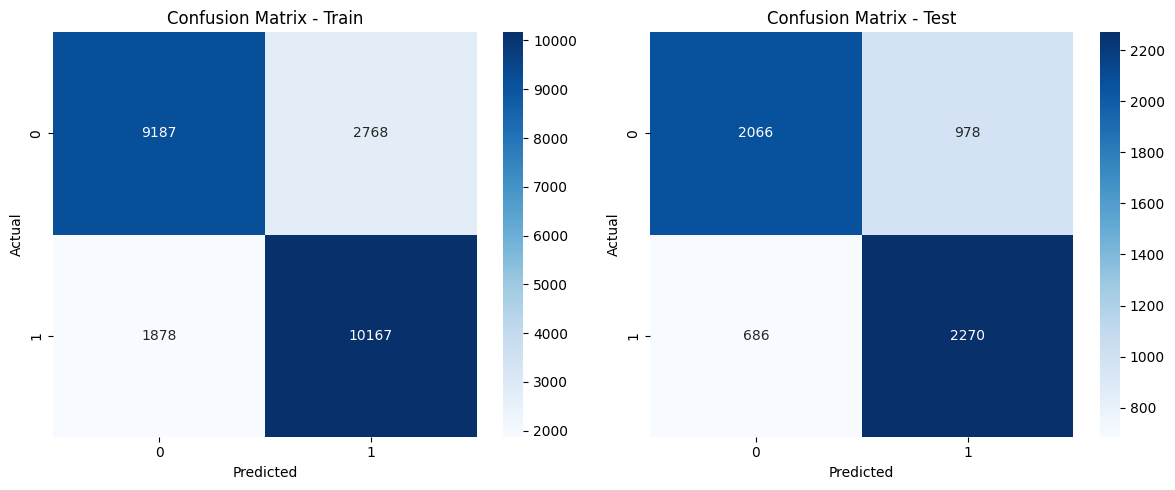

In [68]:
y_pred_bow_final=svm_2.predict(X_test_final_bow)
y_pred_bow_train=svm_2.predict(X_train_final_bow)
cm_test = confusion_matrix(y_test_BOW, y_pred_bow_final)
cm_train = confusion_matrix(y_train_BOW, y_pred_bow_train)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [69]:
from sklearn.metrics import classification_report
print("======================= test ===================")
print(classification_report(y_test_BOW, y_pred_bow_final))
print("======================================================")
print("======================= train ===================")
print(classification_report(y_train_BOW, y_pred_bow_train))

======================= test ===================
              precision    recall  f1-score   support

           0       0.75      0.68      0.71      3044
           1       0.70      0.77      0.73      2956

    accuracy                           0.72      6000
   macro avg       0.72      0.72      0.72      6000
weighted avg       0.73      0.72      0.72      6000

======================= train ===================
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     11955
           1       0.79      0.84      0.81     12045

    accuracy                           0.81     24000
   macro avg       0.81      0.81      0.81     24000
weighted avg       0.81      0.81      0.81     24000



In [70]:
accuracies.append(accuracy_score(y_test_BOW, y_pred_bow_final))
precisions.append(precision_score(y_test_BOW, y_pred_bow_final))
recalls.append(recall_score(y_test_BOW, y_pred_bow_final))
f1s.append(f1_score(y_test_BOW, y_pred_bow_final))

_______

##### **Naive Bayes text Only**

In [71]:
from sklearn.naive_bayes import MultinomialNB
naivebayes_1 =MultinomialNB()
naivebayes_1.fit(X_train_bow, y_train_BOW)
#

MultinomialNB()

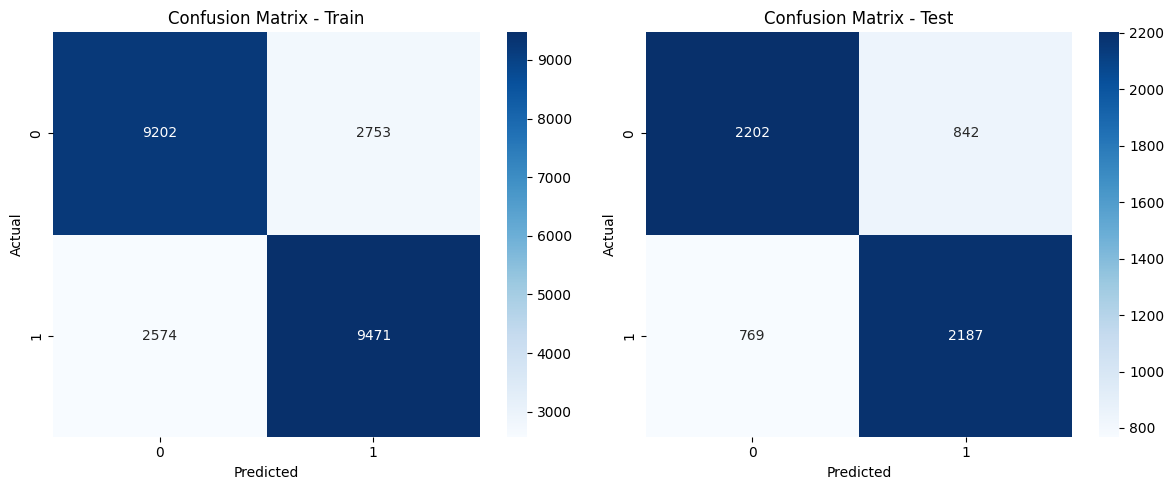

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_bow_text=naivebayes_1.predict(X_test_bow)
y_pred_bow_train=naivebayes_1.predict(X_train_bow)
cm_test = confusion_matrix(y_test_BOW, y_pred_bow_text)
cm_train = confusion_matrix(y_train_BOW, y_pred_bow_train)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#

In [73]:
from sklearn.metrics import classification_report

print(classification_report(y_test_BOW, y_pred_bow_text))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      3044
           1       0.72      0.74      0.73      2956

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000



In [74]:
accuracies.append(accuracy_score(y_test_BOW, y_pred_bow_text))
precisions.append(precision_score(y_test_BOW, y_pred_bow_text))
recalls.append(recall_score(y_test_BOW, y_pred_bow_text))
f1s.append(f1_score(y_test_BOW, y_pred_bow_text))

##### **Naive bayes text +extra numerical features**

In [75]:
from sklearn.naive_bayes import MultinomialNB
naivebayes_2 =MultinomialNB()
naivebayes_2.fit(X_train_final_bow, y_train_BOW)

MultinomialNB()

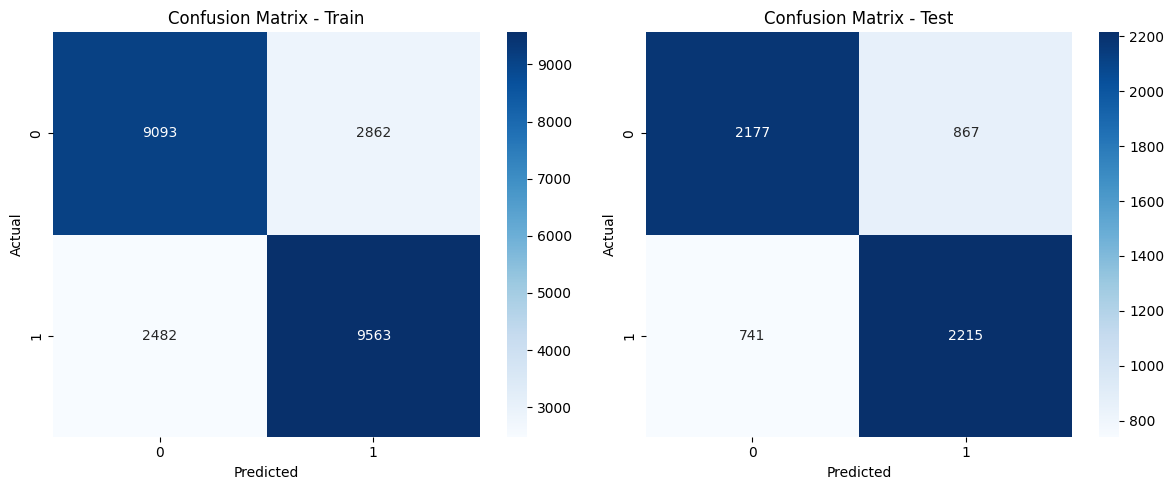

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_bow_final=naivebayes_2.predict(X_test_final_bow)
y_pred_bow_train=naivebayes_2.predict(X_train_final_bow)
cm_test = confusion_matrix(y_test_BOW, y_pred_bow_final)
cm_train = confusion_matrix(y_train_BOW, y_pred_bow_train)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [77]:
from sklearn.metrics import classification_report
print("========================= test =================")
print(classification_report(y_test_BOW, y_pred_bow_final))
print("====================================================")
print("========================= train =================")
print(classification_report(y_train_BOW, y_pred_bow_train))

========================= test =================
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      3044
           1       0.72      0.75      0.73      2956

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000

========================= train =================
              precision    recall  f1-score   support

           0       0.79      0.76      0.77     11955
           1       0.77      0.79      0.78     12045

    accuracy                           0.78     24000
   macro avg       0.78      0.78      0.78     24000
weighted avg       0.78      0.78      0.78     24000



In [78]:
accuracies.append(accuracy_score(y_test_BOW, y_pred_bow_final))
precisions.append(precision_score(y_test_BOW, y_pred_bow_final))
recalls.append(recall_score(y_test_BOW, y_pred_bow_final))
f1s.append

<function list.append(object, /)>

#### **TF–IDF**

##### **Logistic Regression text only**

In [127]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_tfidf, y_train_TFIDF)

LogisticRegression(max_iter=10000)

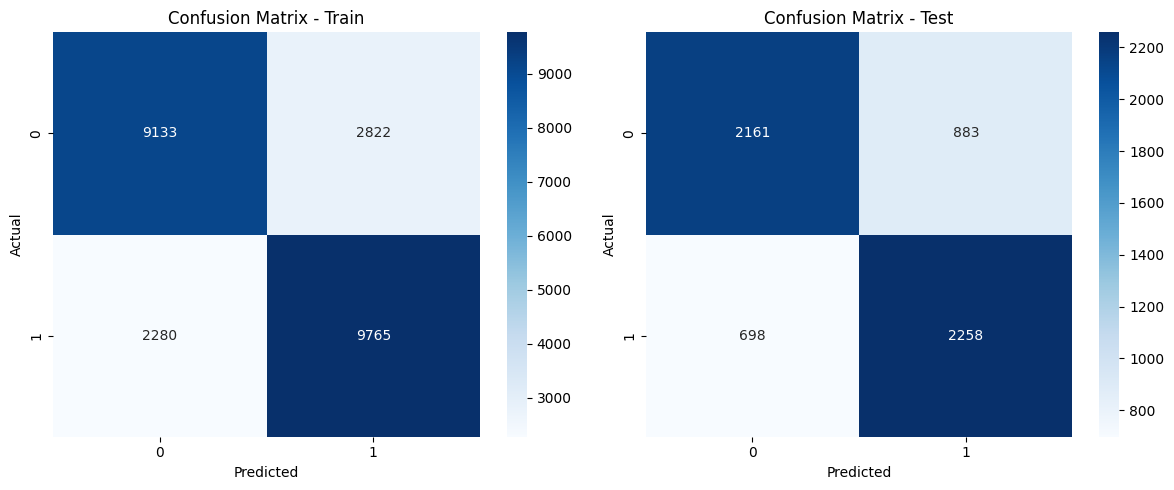

In [128]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_tfidf_text=logreg.predict(X_test_tfidf)
y_pred_tfidf_text_train=logreg.predict(X_train_tfidf)
cm_test = confusion_matrix(y_test_TFIDF, y_pred_tfidf_text)
cm_train = confusion_matrix(y_train_TFIDF, y_pred_tfidf_text_train)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



In [132]:
import joblib
joblib.dump(logreg, 'sentiment_model.pkl')
# Logistic Regression is the best model based on accuracy and F1-score, so i save it

['sentiment_model.pkl']

In [130]:
from sklearn.metrics import classification_report

print(classification_report(y_test_TFIDF, y_pred_tfidf_text))
print(classification_report(y_train_TFIDF, y_pred_tfidf_text_train))

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      3044
           1       0.72      0.76      0.74      2956

    accuracy                           0.74      6000
   macro avg       0.74      0.74      0.74      6000
weighted avg       0.74      0.74      0.74      6000

              precision    recall  f1-score   support

           0       0.80      0.76      0.78     11955
           1       0.78      0.81      0.79     12045

    accuracy                           0.79     24000
   macro avg       0.79      0.79      0.79     24000
weighted avg       0.79      0.79      0.79     24000



In [82]:
accuracies.append(accuracy_score(y_test_TFIDF, y_pred_tfidf_text))
precisions.append(precision_score(y_test_TFIDF, y_pred_tfidf_text))
recalls.append(recall_score(y_test_TFIDF, y_pred_tfidf_text))
f1s.append(f1_score(y_test_TFIDF, y_pred_tfidf_text))

##### **Logistic Regression text + extra numerical features**


In [83]:
logreg_2 = LogisticRegression(max_iter=1000)
logreg_2.fit(X_train_final_tfidf, y_train_TFIDF)
#

LogisticRegression(max_iter=1000)

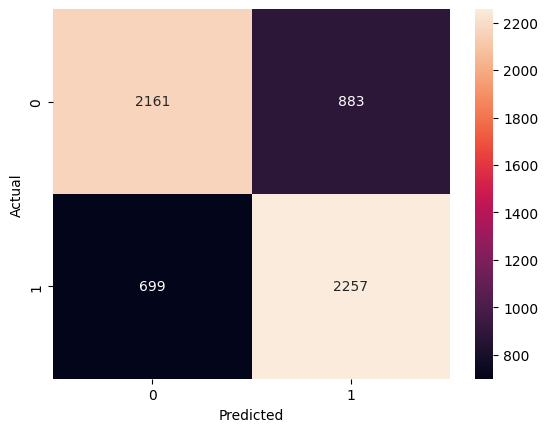

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_tfidf_final=logreg_2.predict(X_test_final_tfidf)
cm = confusion_matrix(y_test_TFIDF, y_pred_tfidf_final)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
#

In [85]:
from sklearn.metrics import classification_report

print(classification_report(y_test_TFIDF, y_pred_tfidf_final))

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      3044
           1       0.72      0.76      0.74      2956

    accuracy                           0.74      6000
   macro avg       0.74      0.74      0.74      6000
weighted avg       0.74      0.74      0.74      6000



In [86]:
accuracies.append(accuracy_score(y_test_TFIDF, y_pred_tfidf_final))
precisions.append(precision_score(y_test_TFIDF, y_pred_tfidf_final))
recalls.append(recall_score(y_test_TFIDF, y_pred_tfidf_final))
f1s.append(f1_score(y_test_TFIDF, y_pred_tfidf_final))

##### **Linear SVM text**

In [87]:
from sklearn.svm import SVC

svm_1=SVC(kernel='linear',C=1.0,random_state=42)
svm_1.fit(X_train_tfidf, y_train_TFIDF)

SVC(kernel='linear', random_state=42)

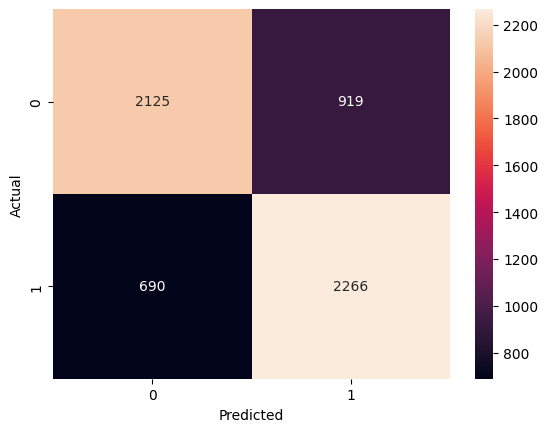

In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_tfidf_text=svm_1.predict(X_test_tfidf)
cm = confusion_matrix(y_test_TFIDF, y_pred_tfidf_text)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [89]:
from sklearn.metrics import classification_report

print(classification_report(y_test_TFIDF, y_pred_tfidf_text))

              precision    recall  f1-score   support

           0       0.75      0.70      0.73      3044
           1       0.71      0.77      0.74      2956

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000



In [90]:
accuracies.append(accuracy_score(y_test_TFIDF, y_pred_tfidf_text))
precisions.append(precision_score(y_test_TFIDF, y_pred_tfidf_text))
recalls.append(recall_score(y_test_TFIDF, y_pred_tfidf_text))
f1s.append(f1_score(y_test_TFIDF, y_pred_tfidf_text))

##### **Linear SVM text +extra numerical features**

In [91]:
svm_2 = SVC(kernel='linear',C=1.0,random_state=42)
svm_2.fit(X_train_final_tfidf, y_train_TFIDF)


SVC(kernel='linear', random_state=42)

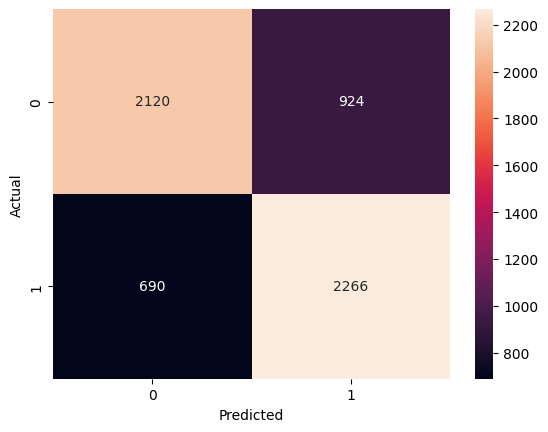

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_tfidf_final=svm_2.predict(X_test_final_tfidf)
cm = confusion_matrix(y_test_TFIDF, y_pred_tfidf_final)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [93]:
from sklearn.metrics import classification_report

print(classification_report(y_test_TFIDF, y_pred_tfidf_final))

              precision    recall  f1-score   support

           0       0.75      0.70      0.72      3044
           1       0.71      0.77      0.74      2956

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000



In [94]:
accuracies.append(accuracy_score(y_test_TFIDF, y_pred_tfidf_final))
precisions.append(precision_score(y_test_TFIDF, y_pred_tfidf_final))
recalls.append(recall_score(y_test_TFIDF, y_pred_tfidf_final))
f1s.append(f1_score(y_test_TFIDF, y_pred_tfidf_final))

##### **Naive Bayes text Only**

In [95]:
from sklearn.naive_bayes import MultinomialNB
naivebayes_1 =MultinomialNB()
naivebayes_1.fit(X_train_tfidf, y_train_TFIDF)

MultinomialNB()

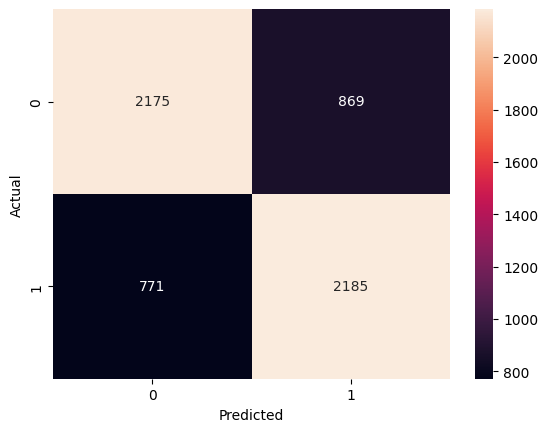

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_tfidf_text=naivebayes_1.predict(X_test_tfidf)
cm = confusion_matrix(y_test_TFIDF, y_pred_tfidf_text)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
#

In [97]:
from sklearn.metrics import classification_report

print(classification_report(y_test_TFIDF, y_pred_tfidf_text))

              precision    recall  f1-score   support

           0       0.74      0.71      0.73      3044
           1       0.72      0.74      0.73      2956

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000



In [98]:
accuracies.append(accuracy_score(y_test_TFIDF, y_pred_tfidf_text))
precisions.append(precision_score(y_test_TFIDF, y_pred_tfidf_text))
recalls.append(recall_score(y_test_TFIDF, y_pred_tfidf_text))
f1s.append(f1_score(y_test_TFIDF, y_pred_tfidf_text))

##### **Naive bayes text +extra numerical features**

In [99]:
from sklearn.naive_bayes import MultinomialNB
naivebayes_2 =MultinomialNB()
naivebayes_2.fit(X_train_final_tfidf, y_train_TFIDF)

MultinomialNB()

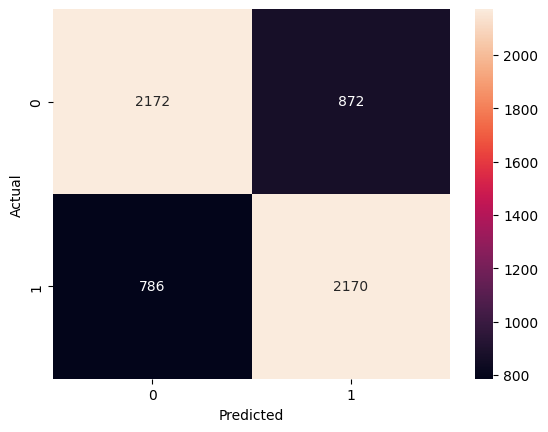

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_tfidf_final=naivebayes_2.predict(X_test_final_tfidf)
cm = confusion_matrix(y_test_TFIDF, y_pred_tfidf_final)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
#

In [101]:
from sklearn.metrics import classification_report

print(classification_report(y_test_TFIDF, y_pred_tfidf_final))
#

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      3044
           1       0.71      0.73      0.72      2956

    accuracy                           0.72      6000
   macro avg       0.72      0.72      0.72      6000
weighted avg       0.72      0.72      0.72      6000



In [102]:
accuracies.append(accuracy_score(y_test_TFIDF, y_pred_tfidf_final))
precisions.append(precision_score(y_test_TFIDF, y_pred_tfidf_final))
recalls.append(recall_score(y_test_TFIDF, y_pred_tfidf_final))
f1s.append(f1_score(y_test_TFIDF, y_pred_tfidf_final))

_____

#### **Word2Vec**

In [103]:
import numpy as np

X_train_w2vec, X_test_w2vec, y_train_w2vec, y_test_w2vec = train_test_split(df_with_lengths[["length","w2v_embedding", "num_verbs", "num_nouns", "num_adjectives"]], df_with_lengths['target'], test_size=0.2, random_state=42)

# Get embeddings as 2D arrays
X_train_embeddings = np.vstack(X_train_w2vec["w2v_embedding"].values)
X_test_embeddings  = np.vstack(X_test_w2vec["w2v_embedding"].values)

# Get numeric features
X_train_numeric = X_train_w2vec[["length","num_verbs","num_nouns","num_adjectives"]].values
X_test_numeric  = X_test_w2vec[["length","num_verbs","num_nouns","num_adjectives"]].values

# Concatenate embeddings + numeric features
X_train_final = np.hstack([X_train_embeddings, X_train_numeric])
X_test_final  = np.hstack([X_test_embeddings, X_test_numeric])


##### **Logistic Regression text only**

In [104]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_embeddings, y_train_w2vec)
#

LogisticRegression(max_iter=2000)

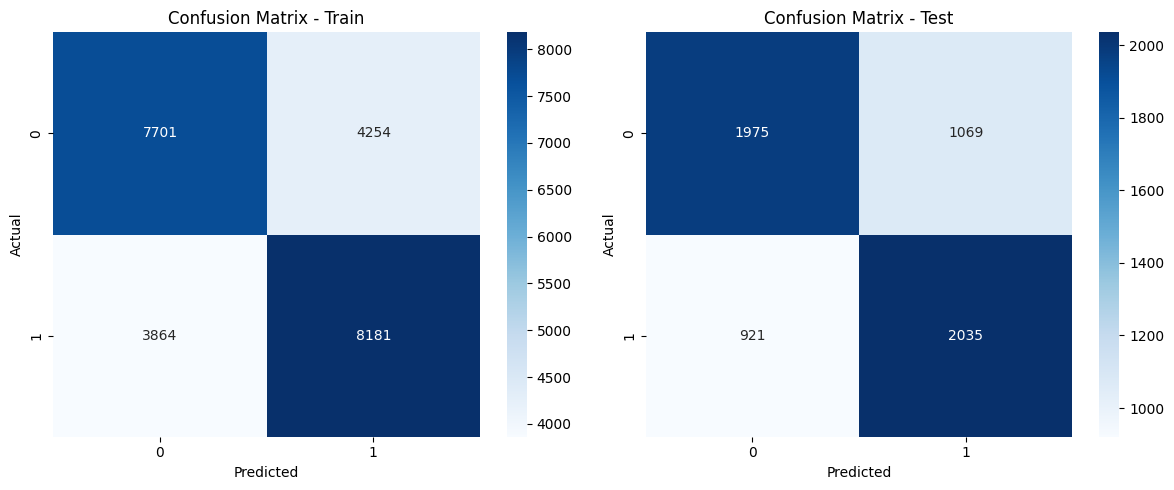

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_w2v_text=logreg.predict(X_test_embeddings)
y_pred_w2v_text_train=logreg.predict(X_train_embeddings)
cm_test = confusion_matrix(y_test_w2vec, y_pred_w2v_text)
cm_train = confusion_matrix(y_train_w2vec, y_pred_w2v_text_train)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()





In [107]:
from sklearn.metrics import classification_report

print(classification_report(y_test_w2vec, y_pred_w2v_text))
print(classification_report(y_train_w2vec, y_pred_w2v_text_train))

              precision    recall  f1-score   support

           0       0.68      0.65      0.66      3044
           1       0.66      0.69      0.67      2956

    accuracy                           0.67      6000
   macro avg       0.67      0.67      0.67      6000
weighted avg       0.67      0.67      0.67      6000

              precision    recall  f1-score   support

           0       0.67      0.64      0.65     11955
           1       0.66      0.68      0.67     12045

    accuracy                           0.66     24000
   macro avg       0.66      0.66      0.66     24000
weighted avg       0.66      0.66      0.66     24000



In [108]:
accuracies.append(accuracy_score(y_test_w2vec, y_pred_w2v_text))
precisions.append(precision_score(y_test_w2vec, y_pred_w2v_text))
recalls.append(recall_score(y_test_w2vec, y_pred_w2v_text))
f1s.append(f1_score(y_test_w2vec, y_pred_w2v_text))

##### **Logistic Regression text + numerical features**

In [109]:
logreg_2 = LogisticRegression(max_iter=2000)
logreg_2.fit(X_train_final, y_train_w2vec)

LogisticRegression(max_iter=2000)

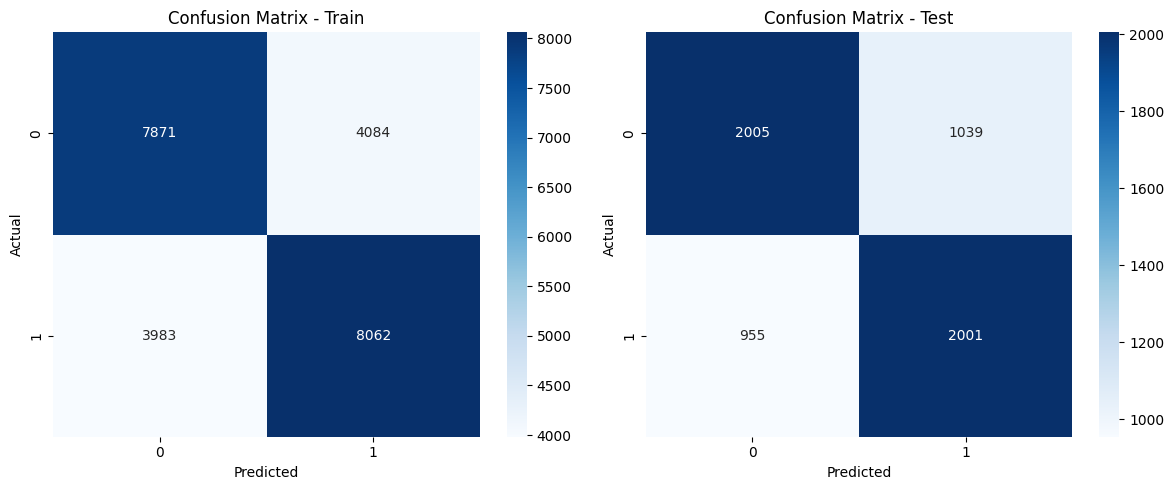

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_w2v_final=logreg_2.predict(X_test_final)
y_pred_w2v_train=logreg_2.predict(X_train_final)
cm_test = confusion_matrix(y_test_w2vec, y_pred_w2v_final)
cm_train = confusion_matrix(y_train_w2vec, y_pred_w2v_train)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



In [111]:
from sklearn.metrics import classification_report

print(classification_report(y_test_w2vec, y_pred_w2v_final))
print(classification_report(y_train_w2vec, y_pred_w2v_train))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      3044
           1       0.66      0.68      0.67      2956

    accuracy                           0.67      6000
   macro avg       0.67      0.67      0.67      6000
weighted avg       0.67      0.67      0.67      6000

              precision    recall  f1-score   support

           0       0.66      0.66      0.66     11955
           1       0.66      0.67      0.67     12045

    accuracy                           0.66     24000
   macro avg       0.66      0.66      0.66     24000
weighted avg       0.66      0.66      0.66     24000



In [112]:
accuracies.append(accuracy_score(y_test_w2vec, y_pred_w2v_final))
precisions.append(precision_score(y_test_w2vec, y_pred_w2v_final))
recalls.append(recall_score(y_test_w2vec, y_pred_w2v_final))
f1s.append(f1_score(y_test_w2vec, y_pred_w2v_final))

##### **Linear Svm text only**

In [113]:
from sklearn.svm import SVC

svm_1=SVC(kernel='linear',C=1.0,random_state=42)
svm_1.fit(X_train_embeddings, y_train_w2vec)

SVC(kernel='linear', random_state=42)

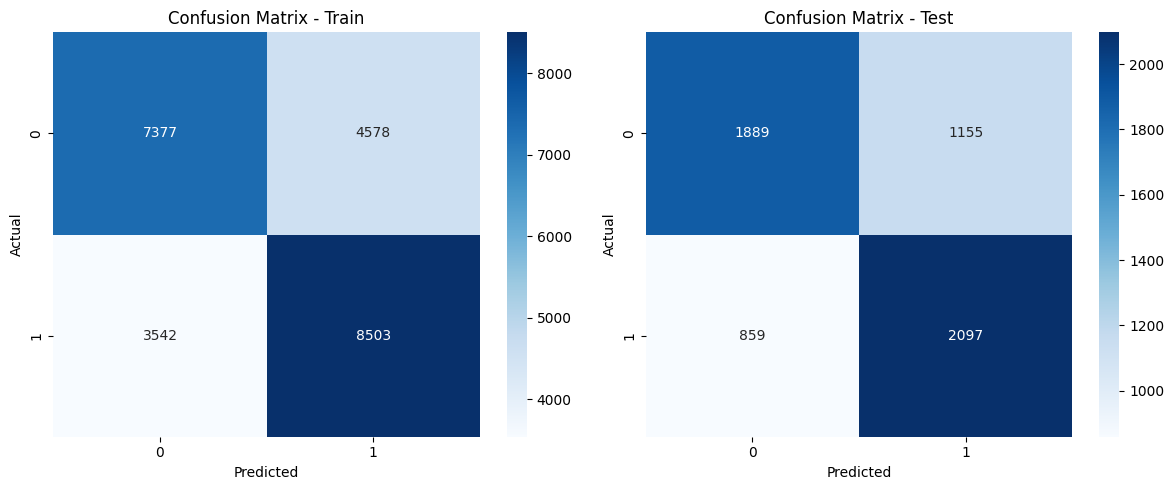

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_w2v_text=svm_1.predict(X_test_embeddings)
y_pred_w2v_text_train=svm_1.predict(X_train_embeddings)
cm_test = confusion_matrix(y_test_w2vec, y_pred_w2v_text)
cm_train = confusion_matrix(y_train_w2vec, y_pred_w2v_text_train)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()




In [115]:
from sklearn.metrics import classification_report

print(classification_report(y_test_w2vec, y_pred_w2v_text))
print(classification_report(y_train_w2vec, y_pred_w2v_text_train))

              precision    recall  f1-score   support

           0       0.69      0.62      0.65      3044
           1       0.64      0.71      0.68      2956

    accuracy                           0.66      6000
   macro avg       0.67      0.66      0.66      6000
weighted avg       0.67      0.66      0.66      6000

              precision    recall  f1-score   support

           0       0.68      0.62      0.65     11955
           1       0.65      0.71      0.68     12045

    accuracy                           0.66     24000
   macro avg       0.66      0.66      0.66     24000
weighted avg       0.66      0.66      0.66     24000



In [116]:
accuracies.append(accuracy_score(y_test_w2vec, y_pred_w2v_text))
precisions.append(precision_score(y_test_w2vec, y_pred_w2v_text))
recalls.append(recall_score(y_test_w2vec, y_pred_w2v_text))
f1s.append(f1_score(y_test_w2vec, y_pred_w2v_text))

##### **Linear Svm text +extra numerical features**

In [117]:
svm_2 = SVC(kernel='linear',C=1.0,random_state=42)
svm_2.fit(X_train_final, y_train_w2vec)
#

SVC(kernel='linear', random_state=42)

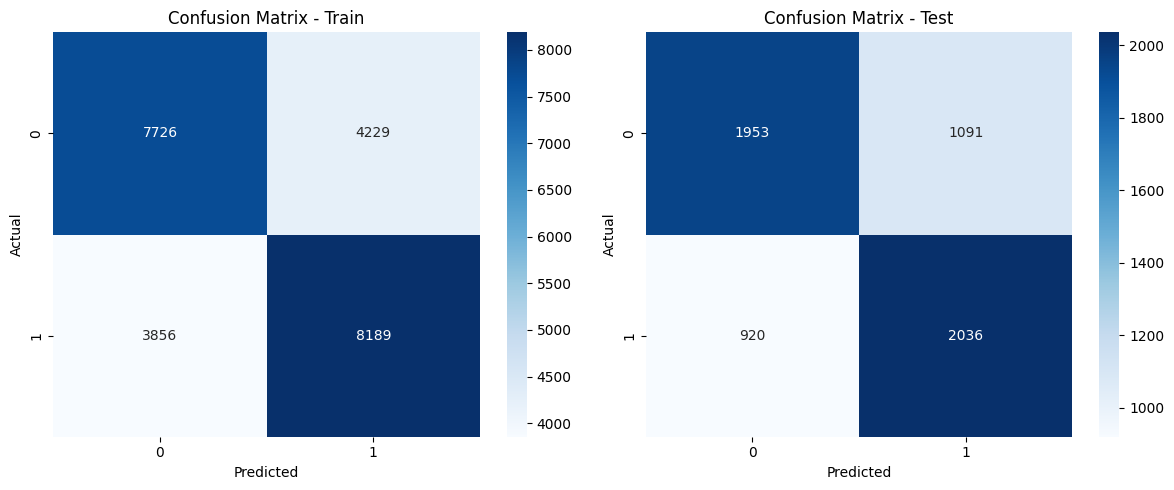

In [118]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_w2v_final=svm_2.predict(X_test_final)
y_pred_w2v_train=svm_2.predict(X_train_final)
cm_test = confusion_matrix(y_test_w2vec, y_pred_w2v_final)
cm_train = confusion_matrix(y_train_w2vec, y_pred_w2v_train)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#

In [119]:
from sklearn.metrics import classification_report

print(classification_report(y_test_w2vec, y_pred_w2v_final))
print(classification_report(y_train_w2vec, y_pred_w2v_train))


              precision    recall  f1-score   support

           0       0.68      0.64      0.66      3044
           1       0.65      0.69      0.67      2956

    accuracy                           0.66      6000
   macro avg       0.67      0.67      0.66      6000
weighted avg       0.67      0.66      0.66      6000

              precision    recall  f1-score   support

           0       0.67      0.65      0.66     11955
           1       0.66      0.68      0.67     12045

    accuracy                           0.66     24000
   macro avg       0.66      0.66      0.66     24000
weighted avg       0.66      0.66      0.66     24000



In [120]:
accuracies.append(accuracy_score(y_test_w2vec, y_pred_w2v_final))
precisions.append(precision_score(y_test_w2vec, y_pred_w2v_final))
recalls.append(recall_score(y_test_w2vec, y_pred_w2v_final))
f1s.append(f1_score(y_test_w2vec, y_pred_w2v_final))

-----

### **Evaluation and Comparison of Baseline Models**

In [121]:
model_names = [
    # BoW
    "LR (BoW, no num)", "LR (BoW, +num)",
    "SVM (BoW, no num)", "SVM (BoW, +num)",
    "NB (BoW, no num)", "NB (BoW, +num)",

    # TF-IDF
    "LR (TF-IDF, no num)", "LR (TF-IDF, +num)",
    "SVM (TF-IDF, no num)", "SVM (TF-IDF, +num)",
    "NB (TF-IDF, no num)", "NB (TF-IDF, +num)",

    # Word2Vec
    "LR (W2V, no num)", "LR (W2V, +num)",
    "SVM (W2V, no num)", "SVM (W2V, +num)"
]


In [124]:
results_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1-score": f1s
})

# Display table
print(results_df)

                   Model  Accuracy  Precision    Recall  F1-score
0       LR (BoW, no num)  0.729500   0.708738  0.765562  0.736055
1         LR (BoW, +num)  0.730667   0.710559  0.764885  0.736722
2      SVM (BoW, no num)  0.721667   0.696877  0.769959  0.731598
3        SVM (BoW, +num)  0.722667   0.698892  0.767930  0.731786
4       NB (BoW, no num)  0.731500   0.722020  0.739851  0.730827
5         NB (BoW, +num)  0.732000   0.718689  0.749323  0.730000
6    LR (TF-IDF, no num)  0.736500   0.718879  0.763870  0.740692
7      LR (TF-IDF, +num)  0.736333   0.718790  0.763532  0.740486
8   SVM (TF-IDF, no num)  0.731833   0.711460  0.766576  0.737991
9     SVM (TF-IDF, +num)  0.731000   0.710345  0.766576  0.737390
10   NB (TF-IDF, no num)  0.726667   0.715455  0.739175  0.727121
11     NB (TF-IDF, +num)  0.723667   0.713346  0.734100  0.723575
12      LR (W2V, no num)  0.668333   0.655606  0.688430  0.671617
13        LR (W2V, +num)  0.667667   0.658224  0.676928  0.667445
14     SVM

Based on the evaluation metrics :

1.   Based on the evaluation metrics, TF-IDF is the best feature representation for this dataset
2.   Logistic Regression with TF-IDF achieved the highest accuracy (0.7365) and F1-score (0.7407)


